In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import feather
import gc

In [2]:
for year in range(2003,2017):
    if year==2003:
        data_ = pd.read_csv("./../data/%d.csv" % year)
        data_ = data_[['Shots_taken_from_location','Cat','Distance_from_hole','Green_to_work_with','Started_at_Z']]
        data = data_
        data_ = None
        gc.collect()
    else:
        data_ = pd.read_csv("./../data/%d.csv" % year)
        data_ = data_[['Shots_taken_from_location','Cat','Distance_from_hole','Green_to_work_with','Started_at_Z']]
        data = pd.concat((data,data_))
        data_ = None
        gc.collect()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data[data.Cat!='Tee Box']

In [4]:
data.shape

(10449771, 5)

In [5]:
data.head()

,Shots_taken_from_location,Cat,Distance_from_hole,Green_to_work_with,Started_at_Z
268672,2,Intermediate Rough,455.140460,43.655204,6.865
268673,3,Fairway,439.086168,63.005699,-4.234
268674,3,Intermediate Rough,504.462646,85.944552,2.293
268675,2,Green,21.972140,NaN,-0.898
268676,3,Fairway,532.638297,24.240408,-0.026


In [6]:
feather.write_dataframe(data, 'difficulty.feather')

In [7]:
irough = data[data.Cat=='Intermediate Rough']

In [8]:
data = None
gc.collect()

331

In [125]:
def make_natural_spline_matrix(x,df):
    t = np.percentile(x,np.linspace(0,100,df+2)[1:-1])
    print t
    X = np.column_stack(([1.0]*len(x),x))
    def d(x,e_k,e_K):
        def pos(x,e):
            x_ = np.copy(x)
            x_[x<=e] = 0.0
            x_[x>e] = (x_[x>e]-e)**3
            return x_
        return (pos(np.copy(x),e_k) - pos(np.copy(x),e_K))/(e_K-e_k)
    for k in range(1,len(t)-1):
        X = np.column_stack((X,d(np.copy(x),t[k],t[-1]) - d(np.copy(x),t[k-1],t[-1])))
    return X

In [126]:
def plot_line(x,y):
    df = pd.DataFrame({'x':x,'y':y})
    df = df.sort_values('x')
    plt.plot(df.x.values,df.y.values)

In [205]:
X_dist = make_natural_spline_matrix(irough.Distance_from_hole.values,15)

[  20.84736084   27.62532294   36.29784231   46.65065629   61.05776772
   90.78614877  247.93784943  339.57625139  391.49230827  432.32310765
  470.52092522  509.3800531   556.73220797  632.26001077  779.58921689]


In [128]:
from sklearn.linear_model import LinearRegression

In [129]:
ols = LinearRegression()

In [130]:
ols.fit(X_dist,irough.Shots_taken_from_location)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

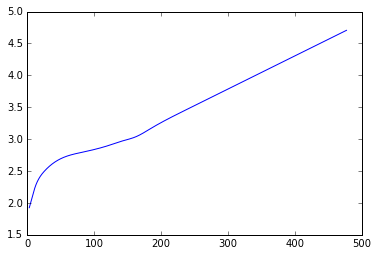

In [131]:
plot_line(irough.Distance_from_hole/3,ols.predict(X_dist))

In [218]:
X_gtww = make_natural_spline_matrix(irough.Green_to_work_with.values,5)

[ 12.33183021  17.99782604  27.09903899  39.90972386  55.41064602]


In [219]:
ols.fit(X_gtww,irough.Shots_taken_from_location)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

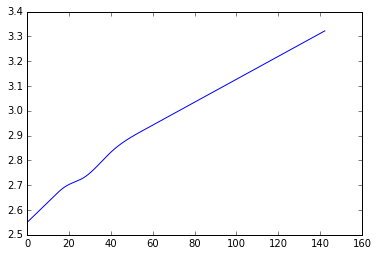

In [220]:
plot_line(irough.Green_to_work_with,ols.predict(X_gtww))

In [221]:
X_elev = make_natural_spline_matrix(irough.Started_at_Z.values,6)

[-7.532      -3.67       -1.876      -0.618       0.249       1.81057143]


In [222]:
ols.fit(X_elev,irough.Shots_taken_from_location)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

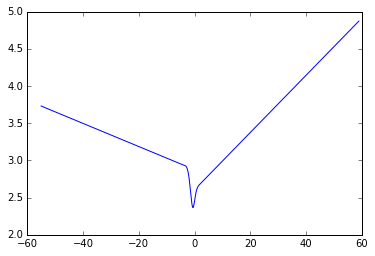

In [223]:
plot_line(irough.Started_at_Z,ols.predict(X_elev))

In [200]:
def tensor_product(mats):
    if len(mats)<2:
        return "I need at least two mats!"
    first = True
    while mats:
        if first:
            res = np.hstack(mats[0].T[:,:,None] * mats[1][None,:,:])
            mats = mats[2:]
            first = False
        else:
            res = np.hstack(res.T[:,:,None] * mats[0][None,:,:])
            mats = mats[1:]
    return res

In [206]:
X = np.hstack((np.ones(len(X_dist[:150000]))[:,None],X_dist[:150000],X_gtww[:150000],X_elev[:150000],
               tensor_product([X_dist[:150000],X_gtww[:150000],X_elev[:150000]])))

In [207]:
X.shape

(150000, 477)

In [208]:
ols.fit(X[:100000],irough.Shots_taken_from_location.values[:100000])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [152]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.3082622176616167

In [170]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.5425992634518548

In [182]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.45563733638456294

In [193]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.4450840539927006

In [204]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.2868592823036484

In [209]:
np.mean((ols.predict(X[100000:150000,:])-irough.values[100000:150000,0])**2)

0.28740377510245824

In [210]:
from sklearn.linear_model import LassoCV

In [211]:
lcv = LassoCV(n_alphas=50,normalize=True,max_iter=10000, tol=0.0001, copy_X=False, cv=5)

In [212]:
lcv.fit(X[:100000],irough.Shots_taken_from_location.values[:100000])

LassoCV(alphas=None, copy_X=False, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=50, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

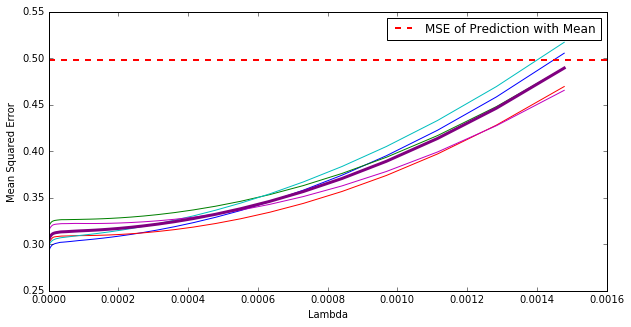

In [213]:
plt.figure(figsize=(10,5))
for fold in range(5):
    plt.plot(lcv.alphas_,lcv.mse_path_[:,fold],lw=1);
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1),lw=3,color="purple");
plt.axhline(np.var(irough.Shots_taken_from_location.values[:50000]),label='MSE of Prediction with Mean',lw=2,ls='--',c='r');
plt.legend();
#plt.ylim(0,12e14);
plt.ylabel('Mean Squared Error');
plt.xlabel('Lambda');

In [215]:
lcv.mse_path_[:,0].mean()

0.31827651412318703

In [101]:
from sklearn.ensemble import GradientBoostingRegressor

In [121]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.008, n_estimators=700, subsample=.5,
                                min_samples_split=2, min_samples_leaf=1, max_depth=3, max_features=None, verbose=5)

In [122]:
gbr.fit(irough.values[:100000,2:],irough.values[:100000,0])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5369           0.0037           47.21s
         2           0.5355           0.0036           47.09s
         3           0.5317           0.0036           47.12s
         4           0.5269           0.0035           47.18s
         5           0.5217           0.0035           47.15s
         6           0.5173           0.0034           47.19s
         7           0.5143           0.0034           47.20s
         8           0.5165           0.0033           47.17s
         9           0.5071           0.0033           47.13s
        10           0.5073           0.0032           47.06s
        11           0.5022           0.0031           46.95s
        12           0.4999           0.0031           46.85s
        13           0.4988           0.0031           46.78s
        14           0.4957           0.0030           46.73s
        15           0.4943           0.0030           46.65s
       

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.008,
             loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=700,
             presort='auto', random_state=None, subsample=0.6, verbose=5,
             warm_start=False)

In [123]:
gbr.feature_importances_ 

array([ 0.72211983,  0.11424214,  0.16363803])

In [124]:
np.mean((gbr.predict(irough.values[100000:150000,2:])-irough.values[100000:150000,0])**2)

0.3070116459937597

In [116]:
np.mean((gbr.predict(irough.values[100000:150000,2:])-irough.values[100000:150000,0])**2)

0.3092090127039229

In [108]:
np.mean((gbr.predict(irough.values[100000:150000,2:])-irough.values[100000:150000,0])**2)

0.3072462456807519